# Convolutional Networks

In [1]:
# As usual, a bit of setup

import pickle
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

y_train:  (49000,)
x_val:  (1000, 3, 32, 32)
x_test:  (1000, 3, 32, 32)
y_val:  (1000,)
x_train:  (49000, 3, 32, 32)
y_test:  (1000,)


## Convolution: Naive forward pass

In [14]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]]])

# Compare your output to for i in range(H_out):
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.21214764175e-08


## Aside: Image processing via convolutions

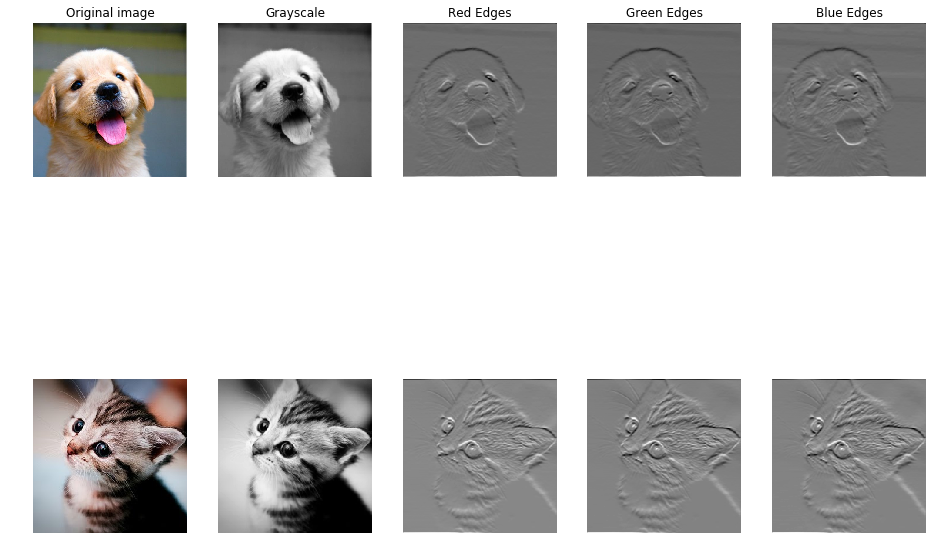

In [33]:
from scipy.misc import imread, imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
#kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2: -d//2, :]

img_size = 200  # Make this smaller if it runs two slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((4, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the red channel.
w[1, 0, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]
# Third filter detects horizontal edges in the green channel.
w[2, 1, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]
# Forth filter detects horizontal edges in the blue channel.
w[3, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale filter, but for the edge detection filter we want 
# to add 128 to each ouput so that nothing is negative.
b = np.array([0, 128, 128, 128])

# Compare the result of convolving each input in x with each filter in w, offsetting by b, and storing the 
# results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize = True):
    """Tiny helper to show images as uint8 and remove axis labels"""
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and results of the conv operation
plt.subplot(2, 5, 1)
imshow_noax(puppy, normalize = False)
plt.title('Original image')
plt.subplot(2, 5, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 5, 3)
imshow_noax(out[0, 1])
plt.title('Red Edges')
plt.subplot(2, 5, 4)
imshow_noax(out[0, 2])
plt.title('Green Edges')
plt.subplot(2, 5, 5)
imshow_noax(out[0, 3])
plt.title('Blue Edges')
plt.subplot(2, 5, 6)
imshow_noax(kitten_cropped, normalize = False)
plt.subplot(2, 5, 7)
imshow_noax(out[1, 0])
plt.subplot(2, 5, 8)
imshow_noax(out[1, 1])
plt.subplot(2, 5, 9)
imshow_noax(out[1, 2])
plt.subplot(2, 5, 10)
imshow_noax(out[1, 3])

## Convolution: Naive backward pass

In [38]:
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-9'
print('Testing conv_backward_naive function...')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function...
dx error:  3.30307315886e-09
dw error:  3.24867348161e-10
db error:  1.27117827481e-11


## Max pooling: Naive forward

In [40]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.16666651573e-08


## Max pooling: Naive backward

In [53]:
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27561731366e-12


## Fast layers

In [60]:
from cs231n.fast_layers import conv_forward_fast, conv_backward_fast
from time import time

x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 0.255352s
Fast: 0.008216s
Speedup: 31.078376x
Difference:  9.14712595889e-12

Testing conv_backward_fast:
Naive: 0.467354s
Fast: 0.008723s
Speedup: 53.577090x
dx difference:  2.26285588393e-11
dw difference:  5.96617388883e-13
db difference:  0.0


In [63]:
from cs231n.fast_layers import max_pool_forward_fast, max_pool_backward_fast

x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.008585s
fast: 0.007661s
speedup: 1.120725x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.497582s
fast: 0.012770s
speedup: 38.965087x
dx difference:  0.0


## Convolutional "sandwich" layers

In [64]:
from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  3.37857149016e-08
dw error:  7.85491914874e-10
db error:  1.32257888699e-10


In [66]:
from cs231n.layer_utils import conv_relu_forward, conv_relu_backward

x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  1.43639073262e-09
dw error:  7.10315070933e-10
db error:  9.81278682556e-12


## Three-layer ConvNet

### Sanity check loss

In [25]:
from cs231n.classifiers.cnn import * 

model = ThreeLayerConvNet()

N = 50
x = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(x, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(x, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.30258635775
Initial loss (with regularization):  2.50852709607


### Gradient check

In [4]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
x = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(x, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(x, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, e))

W1 max relative error: 1.833672e-01
W2 max relative error: 1.109824e-02
W3 max relative error: 1.234763e-05
b1 max relative error: 7.644622e-06
b2 max relative error: 3.656526e-07
b3 max relative error: 1.821089e-09


### Overfit small data

In [5]:
num_train = 100
small_data = {
  'x_train': data['x_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'x_val': data['x_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale = 1e-3)

solver = Solver(model, small_data,
                num_epochs = 20, batch_size = 20,
                update_rule= 'adam',
                optim_config={
                  'learning_rate': 5e-4,
                },
                verbose = True, print_every = 1)
solver.train()

(Iteration 1 / 100) loss: 2.302452
(Epoch 0 /20) train acc: 0.120000; val_acc: 0.105000
(Iteration 2 / 100) loss: 2.286828
(Iteration 3 / 100) loss: 2.202568
(Iteration 4 / 100) loss: 2.613308
(Iteration 5 / 100) loss: 2.324652
(Epoch 1 /20) train acc: 0.240000; val_acc: 0.142000
(Iteration 6 / 100) loss: 2.110518
(Iteration 7 / 100) loss: 2.161936
(Iteration 8 / 100) loss: 2.091451
(Iteration 9 / 100) loss: 2.167948
(Iteration 10 / 100) loss: 2.367221
(Epoch 2 /20) train acc: 0.280000; val_acc: 0.110000
(Iteration 11 / 100) loss: 1.967172
(Iteration 12 / 100) loss: 1.976774
(Iteration 13 / 100) loss: 2.009471
(Iteration 14 / 100) loss: 1.928109
(Iteration 15 / 100) loss: 1.969123
(Epoch 3 /20) train acc: 0.300000; val_acc: 0.174000
(Iteration 16 / 100) loss: 1.905604
(Iteration 17 / 100) loss: 1.756308
(Iteration 18 / 100) loss: 1.901364
(Iteration 19 / 100) loss: 1.829878
(Iteration 20 / 100) loss: 1.808906
(Epoch 4 /20) train acc: 0.410000; val_acc: 0.175000
(Iteration 21 / 100) los

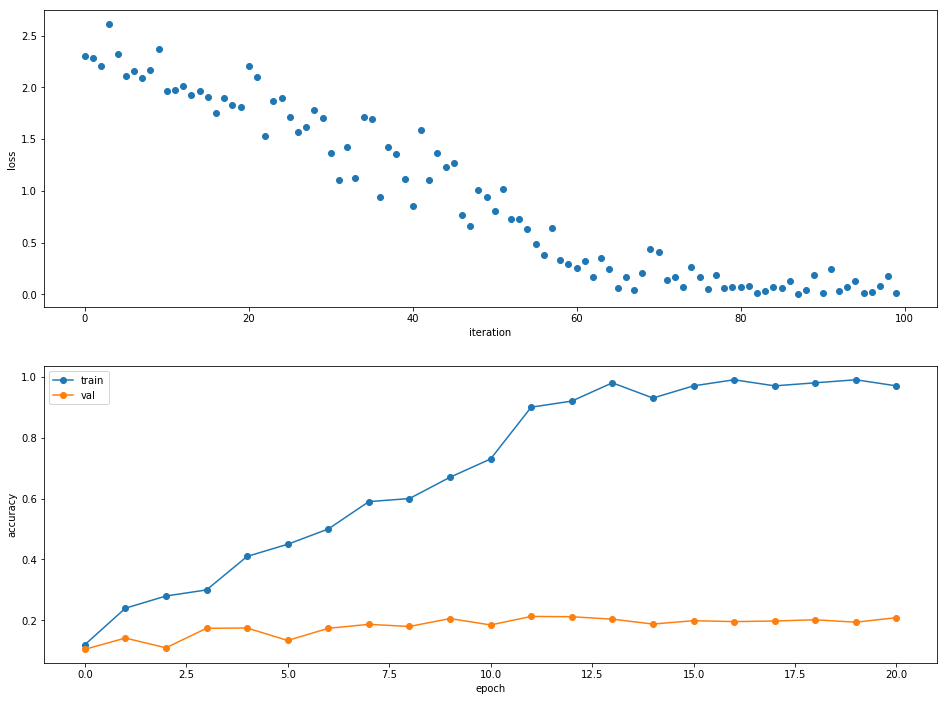

In [6]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### Train the net

In [49]:
model = ThreeLayerConvNet(weight_scale = 1e-3, hidden_dim = 500, reg = 1e-3)

solver = Solver(model, data,
                num_epochs = 5, batch_size = 50,
                update_rule = 'adam',
                optim_config={
                  'learning_rate': 5e-4,
                },
                verbose = True, print_every = 20)
solver.train()

(Iteration 1 / 4900) loss: 2.304527
(Epoch 0 /5) train acc: 0.103000; val_acc: 0.119000
(Iteration 21 / 4900) loss: 1.878808
(Iteration 41 / 4900) loss: 1.958472
(Iteration 61 / 4900) loss: 1.616295
(Iteration 81 / 4900) loss: 1.941978
(Iteration 101 / 4900) loss: 1.893352
(Iteration 121 / 4900) loss: 1.575159
(Iteration 141 / 4900) loss: 1.637510
(Iteration 161 / 4900) loss: 1.727833
(Iteration 181 / 4900) loss: 1.968142
(Iteration 201 / 4900) loss: 1.578933
(Iteration 221 / 4900) loss: 1.708825
(Iteration 241 / 4900) loss: 1.622986
(Iteration 261 / 4900) loss: 1.367943
(Iteration 281 / 4900) loss: 1.879450
(Iteration 301 / 4900) loss: 1.505363
(Iteration 321 / 4900) loss: 1.415864
(Iteration 341 / 4900) loss: 1.175183
(Iteration 361 / 4900) loss: 1.461535
(Iteration 381 / 4900) loss: 1.527566
(Iteration 401 / 4900) loss: 1.451588
(Iteration 421 / 4900) loss: 1.690248
(Iteration 441 / 4900) loss: 1.731388
(Iteration 461 / 4900) loss: 1.460062
(Iteration 481 / 4900) loss: 1.562356
(Ite

(Iteration 4101 / 4900) loss: 0.902048
(Iteration 4121 / 4900) loss: 1.133116
(Iteration 4141 / 4900) loss: 0.976230
(Iteration 4161 / 4900) loss: 1.124744
(Iteration 4181 / 4900) loss: 1.131724
(Iteration 4201 / 4900) loss: 1.041268
(Iteration 4221 / 4900) loss: 0.719475
(Iteration 4241 / 4900) loss: 1.210076
(Iteration 4261 / 4900) loss: 0.858819
(Iteration 4281 / 4900) loss: 1.043647
(Iteration 4301 / 4900) loss: 1.256283
(Iteration 4321 / 4900) loss: 1.262155
(Iteration 4341 / 4900) loss: 0.915929
(Iteration 4361 / 4900) loss: 1.171214
(Iteration 4381 / 4900) loss: 1.082603
(Iteration 4401 / 4900) loss: 0.941190
(Iteration 4421 / 4900) loss: 0.909436
(Iteration 4441 / 4900) loss: 0.748369
(Iteration 4461 / 4900) loss: 0.893502
(Iteration 4481 / 4900) loss: 0.792001
(Iteration 4501 / 4900) loss: 1.119465
(Iteration 4521 / 4900) loss: 1.054761
(Iteration 4541 / 4900) loss: 0.816814
(Iteration 4561 / 4900) loss: 0.864816
(Iteration 4581 / 4900) loss: 0.930330
(Iteration 4601 / 4900) l

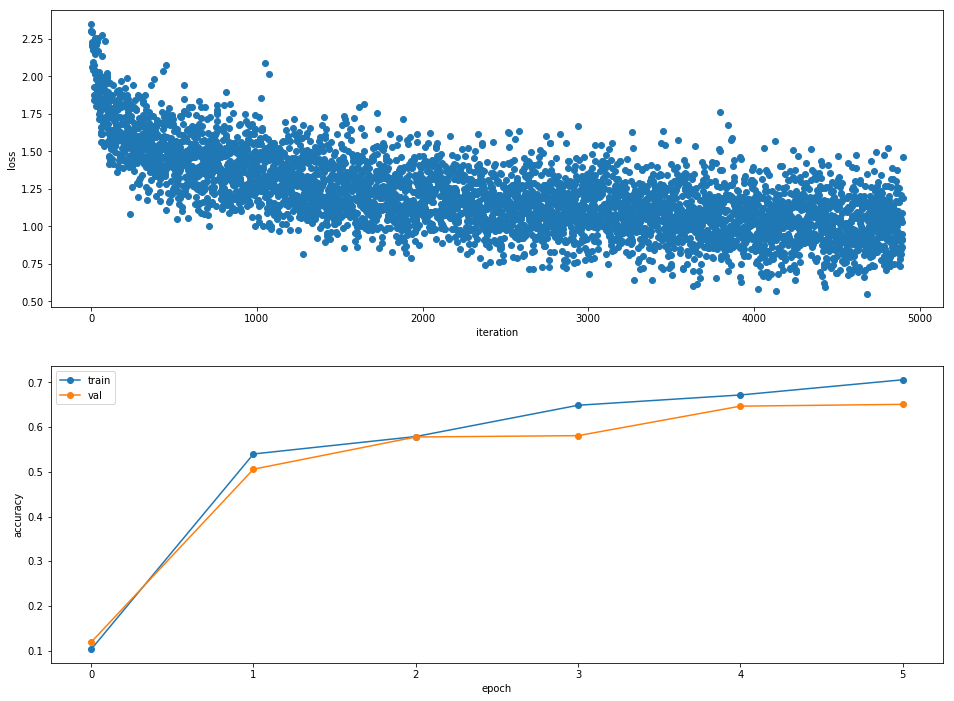

In [50]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### Visualize Filters

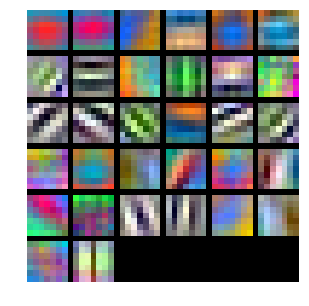

In [52]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

## Spatial Batch Normalization

### Spatial bathc normalization: forward

In [59]:
# Check the training-time forward pass by checking means and variances of features both before and after 
# spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 10.3022107   10.75356145  10.20596131]
  Stds:  [ 3.80054818  3.56408819  3.70141653]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [  6.49480469e-16  -1.03250741e-15  -5.39845946e-16]
  Stds:  [ 0.99999965  0.99999961  0.99999964]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.  7.  8.]
  Stds:  [ 2.99999896  3.99999843  4.99999818]


In [64]:
# Check the test-time forward pass by running the training-time forward pass many times to warm up the running 
# averages, and then checking the means and variances of activations after a test-time forward pass.

N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
    x = 2.3 * np.random.randn(N, C, H, W) + 13
    spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [ 0.03191241  0.05161626  0.0274819   0.00608307]
  stds:  [ 0.98351851  1.00187251  0.99036827  1.01769813]


### Spatial batch normalization: backward

In [66]:
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  3.95395922442e-07
dgamma error:  1.61891095368e-11
dbeta error:  4.3003908274e-12


## Experiment!

In [15]:
from cs231n.classifiers.cnn import * 

model = FiveLayerConvNet()

N = 50
x = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(x, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(x, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.30258509299
Initial loss (with regularization):  2.31702841042


In [13]:
num_inputs = 2
input_dim = (3, 32, 32)
reg = 0.0
num_classes = 10
x = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size = num_inputs)

model = FiveLayerConvNet(num_filters=[4, 8, 16], filter_size=[5, 5, 5],
                         input_dim=input_dim, hidden_dim = 20, reg = reg, 
                         dtype=np.float64)
loss, grads = model.loss(x, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(x, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, e))

W1 max relative error: 4.009519e-02
W2 max relative error: 4.699220e-02
W3 max relative error: 4.941811e-02
W4 max relative error: 4.446579e-02
W5 max relative error: 3.382245e-02
b1 max relative error: 2.324838e-02
b2 max relative error: 3.342826e-01
b3 max relative error: 1.000000e+00
b4 max relative error: 1.000000e+00
b5 max relative error: 1.414949e-09


In [20]:
num_train = 100
small_data = {
  'x_train': data['x_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'x_val': data['x_val'],
  'y_val': data['y_val'],
}

model = FiveLayerConvNet(weight_scale = 1e-2)

solver = Solver(model, small_data,
                num_epochs = 30, batch_size = 20,
                update_rule= 'adam',
                optim_config={
                  'learning_rate': 5e-3,
                },
                verbose = True, print_every = 1)
solver.train()

(Iteration 1 / 150) loss: 2.302615
(Epoch 0 /30) train acc: 0.130000; val_acc: 0.112000
(Iteration 2 / 150) loss: 2.295322
(Iteration 3 / 150) loss: 2.328618
(Iteration 4 / 150) loss: 2.297609
(Iteration 5 / 150) loss: 2.301489
(Epoch 1 /30) train acc: 0.130000; val_acc: 0.079000
(Iteration 6 / 150) loss: 2.299252
(Iteration 7 / 150) loss: 2.284395
(Iteration 8 / 150) loss: 2.192909
(Iteration 9 / 150) loss: 2.273508
(Iteration 10 / 150) loss: 2.451956
(Epoch 2 /30) train acc: 0.130000; val_acc: 0.079000
(Iteration 11 / 150) loss: 2.151645
(Iteration 12 / 150) loss: 2.231867
(Iteration 13 / 150) loss: 2.257305
(Iteration 14 / 150) loss: 2.351670
(Iteration 15 / 150) loss: 2.234546
(Epoch 3 /30) train acc: 0.130000; val_acc: 0.079000
(Iteration 16 / 150) loss: 2.278270
(Iteration 17 / 150) loss: 2.202325
(Iteration 18 / 150) loss: 2.267044
(Iteration 19 / 150) loss: 2.152112
(Iteration 20 / 150) loss: 2.357538
(Epoch 4 /30) train acc: 0.130000; val_acc: 0.079000
(Iteration 21 / 150) los

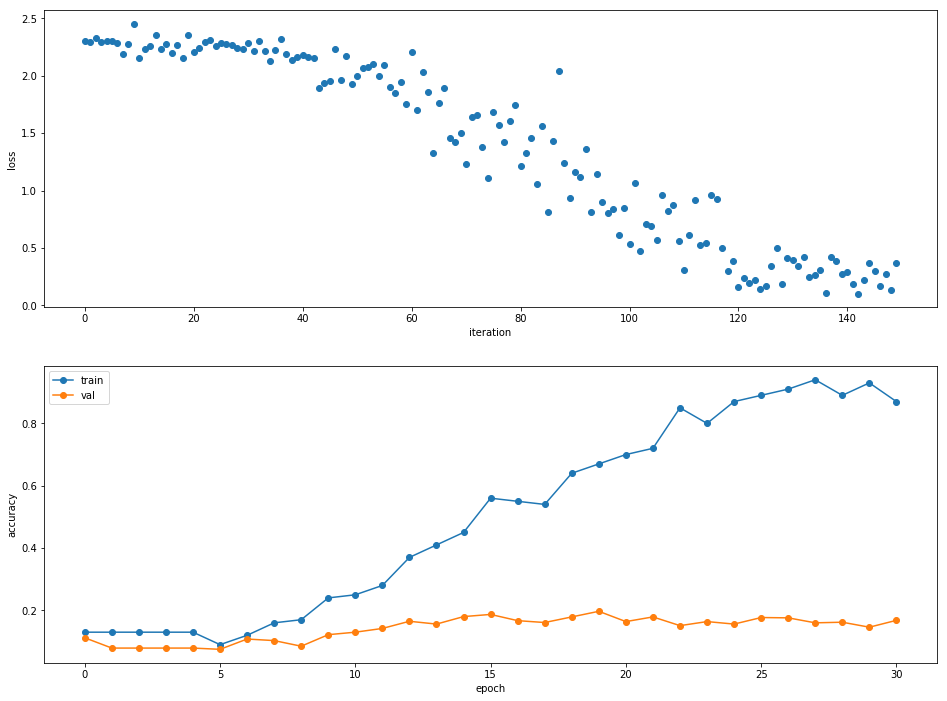

In [21]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### Cross-Validation

In [3]:
%%time
num_train = 5000
small_data = {
    'x_train': data['x_train'][:num_train], 
    'y_train': data['y_train'][:num_train], 
    'x_val': data['x_val'], 
    'y_val': data['y_val']
}

best_model = None
best_val_acc = 0.0
results = {}

learning_rates = 10 ** np.arange(-6.0, -1.0, 1.0)
weight_scales = 10 ** np.arange(-5.0, -1.0, 1.0)
regs = 10 ** np.arange(-5.0, -2.0, 1.0)

for weight_scale in weight_scales:
    for learning_rate in learning_rates:
        for reg in regs:
            print('Training net with weight_scale = %.5f, learning_rate = %.6f, reg strength = %.4f' % 
                  (weight_scale, learning_rate, reg))
            
            model = FiveLayerConvNet(weight_scale = weight_scale, input_dim = [3, 32, 32], 
                                     num_filters=[8, 16, 32], filter_size=[5, 5, 5], 
                                     hidden_dim = 100, reg = reg, dtype = 'float64')
            solver = Solver(model, small_data, num_epochs = 10, batch_size = 128, update_rule= 'adam', 
                            optim_config={
                                'learning_rate': learning_rate
                            }, 
                            verbose = True, print_every = 1000)
            solver.train()
            
            train_acc = solver.train_acc_history[-1]
            val_acc = solver.val_acc_history[-1]
            results[(weight_scale, learning_rate, reg)] = (train_acc, val_acc)
            print('train acc: %.4f; validation acc: %.4f' % (train_acc, val_acc))
            
            if val_acc > best_val_acc:
                best_model = model
                best_val_acc = val_acc

Training net with weight_scale = 0.00001, learning_rate = 0.000001, reg strength = 0.0001
(Iteration 1 / 390) loss: 2.302585
(Epoch 0 /10) train acc: 0.108000; val_acc: 0.079000
(Epoch 1 /10) train acc: 0.099000; val_acc: 0.105000
(Epoch 2 /10) train acc: 0.119000; val_acc: 0.105000
(Epoch 3 /10) train acc: 0.099000; val_acc: 0.105000
(Epoch 4 /10) train acc: 0.086000; val_acc: 0.105000
(Epoch 5 /10) train acc: 0.115000; val_acc: 0.105000
(Epoch 6 /10) train acc: 0.119000; val_acc: 0.105000
(Epoch 7 /10) train acc: 0.107000; val_acc: 0.105000
(Epoch 8 /10) train acc: 0.111000; val_acc: 0.102000
(Epoch 9 /10) train acc: 0.097000; val_acc: 0.102000
(Epoch 10 /10) train acc: 0.084000; val_acc: 0.102000
train acc: 0.0840; validation acc: 0.1020
Training net with weight_scale = 0.00001, learning_rate = 0.000001, reg strength = 0.0010
(Iteration 1 / 390) loss: 2.302585
(Epoch 0 /10) train acc: 0.086000; val_acc: 0.079000
(Epoch 1 /10) train acc: 0.100000; val_acc: 0.079000
(Epoch 2 /10) trai

(Iteration 1 / 390) loss: 2.302585
(Epoch 0 /10) train acc: 0.103000; val_acc: 0.087000
(Epoch 1 /10) train acc: 0.103000; val_acc: 0.087000
(Epoch 2 /10) train acc: 0.100000; val_acc: 0.078000
(Epoch 3 /10) train acc: 0.100000; val_acc: 0.102000
(Epoch 4 /10) train acc: 0.101000; val_acc: 0.102000
(Epoch 5 /10) train acc: 0.111000; val_acc: 0.102000
(Epoch 6 /10) train acc: 0.112000; val_acc: 0.102000
(Epoch 7 /10) train acc: 0.116000; val_acc: 0.102000
(Epoch 8 /10) train acc: 0.103000; val_acc: 0.102000
(Epoch 9 /10) train acc: 0.103000; val_acc: 0.102000
(Epoch 10 /10) train acc: 0.099000; val_acc: 0.102000
train acc: 0.0990; validation acc: 0.1020
Training net with weight_scale = 0.00010, learning_rate = 0.000010, reg strength = 0.0001
(Iteration 1 / 390) loss: 2.302585
(Epoch 0 /10) train acc: 0.110000; val_acc: 0.113000
(Epoch 1 /10) train acc: 0.094000; val_acc: 0.113000
(Epoch 2 /10) train acc: 0.087000; val_acc: 0.113000
(Epoch 3 /10) train acc: 0.112000; val_acc: 0.113000
(E

(Iteration 1 / 390) loss: 2.302589
(Epoch 0 /10) train acc: 0.103000; val_acc: 0.115000
(Epoch 1 /10) train acc: 0.100000; val_acc: 0.078000
(Epoch 2 /10) train acc: 0.116000; val_acc: 0.078000
(Epoch 3 /10) train acc: 0.108000; val_acc: 0.079000
(Epoch 4 /10) train acc: 0.091000; val_acc: 0.079000
(Epoch 5 /10) train acc: 0.104000; val_acc: 0.079000
(Epoch 6 /10) train acc: 0.096000; val_acc: 0.079000
(Epoch 7 /10) train acc: 0.123000; val_acc: 0.079000
(Epoch 8 /10) train acc: 0.167000; val_acc: 0.171000
(Epoch 9 /10) train acc: 0.149000; val_acc: 0.173000
(Epoch 10 /10) train acc: 0.162000; val_acc: 0.177000
train acc: 0.1620; validation acc: 0.1770
Training net with weight_scale = 0.00100, learning_rate = 0.000010, reg strength = 0.0010
(Iteration 1 / 390) loss: 2.302620
(Epoch 0 /10) train acc: 0.094000; val_acc: 0.119000
(Epoch 1 /10) train acc: 0.086000; val_acc: 0.078000
(Epoch 2 /10) train acc: 0.089000; val_acc: 0.102000
(Epoch 3 /10) train acc: 0.096000; val_acc: 0.113000
(E

(Iteration 1 / 390) loss: 2.306082
(Epoch 0 /10) train acc: 0.100000; val_acc: 0.090000
(Epoch 1 /10) train acc: 0.120000; val_acc: 0.112000
(Epoch 2 /10) train acc: 0.123000; val_acc: 0.124000
(Epoch 3 /10) train acc: 0.111000; val_acc: 0.124000
(Epoch 4 /10) train acc: 0.118000; val_acc: 0.115000
(Epoch 5 /10) train acc: 0.139000; val_acc: 0.137000
(Epoch 6 /10) train acc: 0.178000; val_acc: 0.171000
(Epoch 7 /10) train acc: 0.214000; val_acc: 0.209000
(Epoch 8 /10) train acc: 0.228000; val_acc: 0.228000
(Epoch 9 /10) train acc: 0.245000; val_acc: 0.235000
(Epoch 10 /10) train acc: 0.244000; val_acc: 0.235000
train acc: 0.2440; validation acc: 0.2350
Training net with weight_scale = 0.01000, learning_rate = 0.000100, reg strength = 0.0001
(Iteration 1 / 390) loss: 2.302812
(Epoch 0 /10) train acc: 0.102000; val_acc: 0.103000
(Epoch 1 /10) train acc: 0.162000; val_acc: 0.178000
(Epoch 2 /10) train acc: 0.259000; val_acc: 0.251000
(Epoch 3 /10) train acc: 0.279000; val_acc: 0.265000
(E

In [4]:
file = open('fivelayerconvnet.pickle', 'wb')
pickle.dump(results, file)
file.close

In [3]:
with open('fivelayerconvnet.pickle', 'rb') as file:
    results = pickle.load(file)

from math import log
result = np.asarray([[log(k[0], 10), log(k[1], 10), log(k[2], 10), v[0], v[1]] for k, v in results.items()])

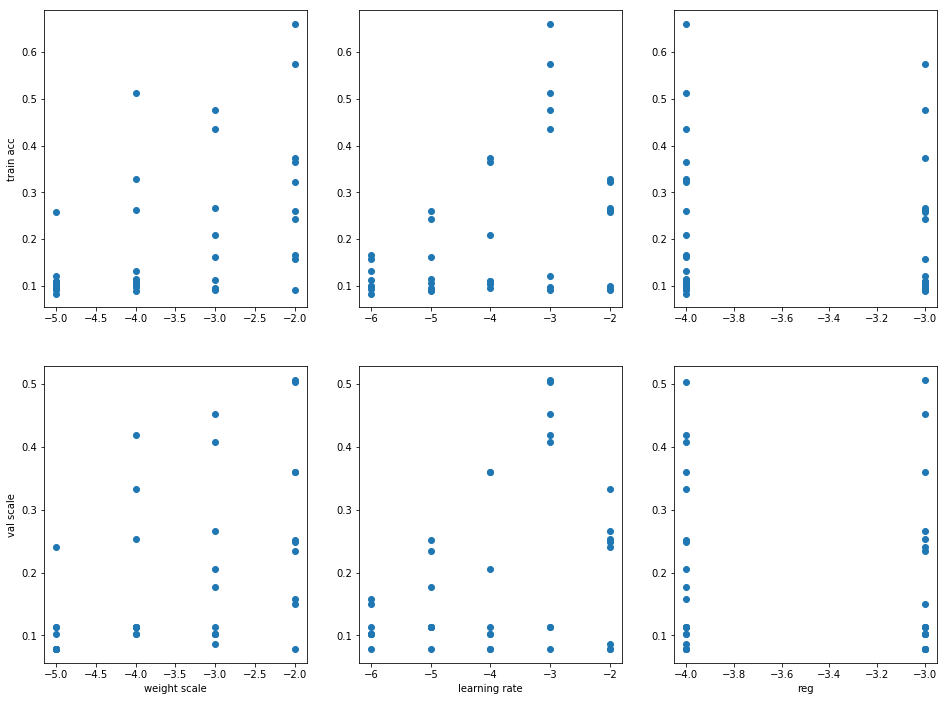

In [4]:
plt.subplot(2, 3, 1)
plt.plot(result[:, 0], result[:, 3], 'o')
plt.ylabel('train acc')

plt.subplot(2, 3, 2)
plt.plot(result[:, 1], result[:, 3], 'o')

plt.subplot(2, 3, 3)
plt.plot(result[:, 2], result[:, 3], 'o')


plt.subplot(2, 3, 4)
plt.plot(result[:, 0], result[:, 4], 'o')
plt.xlabel('weight scale')
plt.ylabel('val scale')

plt.subplot(2, 3, 5)
plt.plot(result[:, 1], result[:, 4], 'o')
plt.xlabel('learning rate')

plt.subplot(2, 3, 6)
plt.plot(result[:, 2], result[:, 4], 'o')
plt.xlabel('reg')

plt.show()

In [5]:
(weight_scale, learning_rate, reg) = [k for k,v in results.items() if v == max(results.values())][0]
print(weight_scale, learning_rate, reg)

0.01 0.001 0.0001


In [6]:
(weight_scale, learning_rate, reg) = [0.01, 0.001, 0.0001]
model = FiveLayerConvNet(weight_scale = weight_scale, input_dim = [3, 32, 32], num_filters=[4, 8, 16], 
                         filter_size=[5, 5, 5], hidden_dim = 100, reg = reg, dtype = 'float64')
solver = Solver(model, data, num_epochs = 20, batch_size = 128, update_rule= 'adam', 
                optim_config={
                    'learning_rate': learning_rate
                }, 
                verbose = True, print_every = 1000)
solver.train()

(Iteration 1 / 7640) loss: 2.302758
(Epoch 0 /20) train acc: 0.096000; val_acc: 0.132000
(Epoch 1 /20) train acc: 0.409000; val_acc: 0.441000
(Epoch 2 /20) train acc: 0.526000; val_acc: 0.510000
(Iteration 1001 / 7640) loss: 1.307906
(Epoch 3 /20) train acc: 0.568000; val_acc: 0.537000
(Epoch 4 /20) train acc: 0.564000; val_acc: 0.570000
(Epoch 5 /20) train acc: 0.587000; val_acc: 0.586000
(Iteration 2001 / 7640) loss: 1.087813
(Epoch 6 /20) train acc: 0.649000; val_acc: 0.596000
(Epoch 7 /20) train acc: 0.634000; val_acc: 0.601000
(Iteration 3001 / 7640) loss: 0.945951
(Epoch 8 /20) train acc: 0.655000; val_acc: 0.614000
(Epoch 9 /20) train acc: 0.655000; val_acc: 0.601000
(Epoch 10 /20) train acc: 0.664000; val_acc: 0.628000
(Iteration 4001 / 7640) loss: 0.955861
(Epoch 11 /20) train acc: 0.659000; val_acc: 0.635000
(Epoch 12 /20) train acc: 0.679000; val_acc: 0.620000
(Epoch 13 /20) train acc: 0.695000; val_acc: 0.621000
(Iteration 5001 / 7640) loss: 1.074463
(Epoch 14 /20) train ac

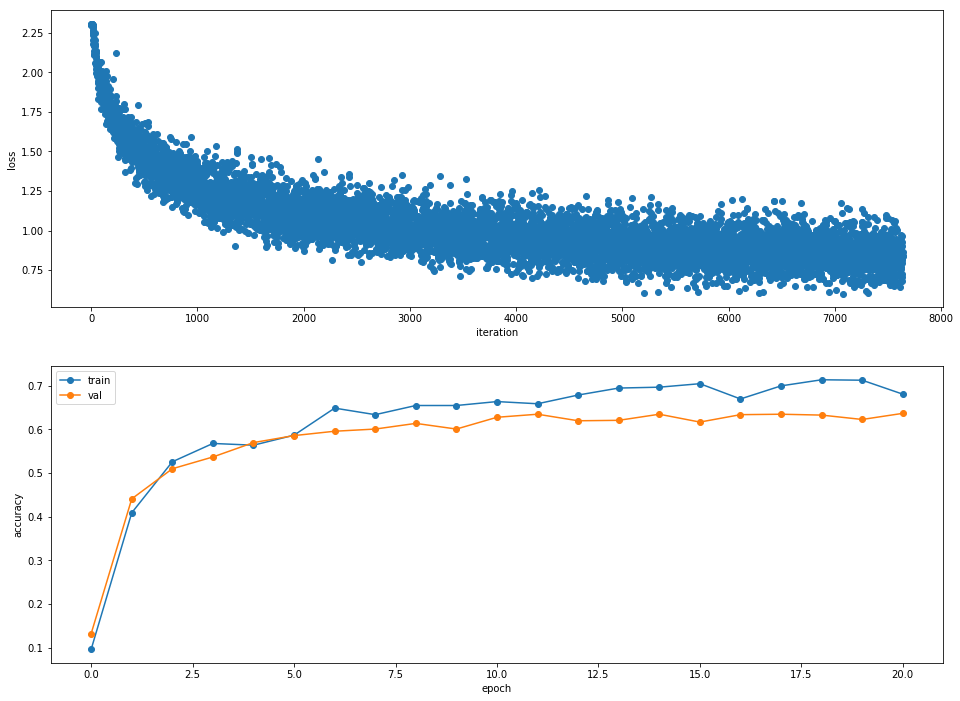

In [7]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [8]:
x_val = data['x_val']
y_val = data['y_val']
x_test = data['x_test']
y_test = data['y_test']

y_test_pred = np.argmax(model.loss(x_test), axis=1)
y_val_pred = np.argmax(model.loss(x_val), axis=1)
print('Validation set accuracy: ', (y_val_pred == y_val).mean())
print('Test set accuracy: ', (y_test_pred == y_test).mean())

Validation set accuracy:  0.637
Test set accuracy:  0.635
